# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [21]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import spacy
import re
from sklearn.preprocessing import OrdinalEncoder

In [22]:
#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

#plt.style.use('seaborn')

In [23]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [24]:
df_reviews = pd.read_csv('dataset\imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

<>:1: SyntaxWarning: invalid escape sequence '\i'
<>:1: SyntaxWarning: invalid escape sequence '\i'
C:\Users\jimen\AppData\Local\Temp\ipykernel_38244\984704702.py:1: SyntaxWarning: invalid escape sequence '\i'
  df_reviews = pd.read_csv('dataset\imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})


In [25]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [26]:
"""Vamos a hechar un vistazo rapido al dataset de las peliculas con sus reseñas 
y como es que esta distribuida la informacion."""

display(df_reviews.sort_values(by='start_year').head(10))

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
10014,tt0177707,short,Dickson Experimental Sound Film,Dickson Experimental Sound Film,1894,\N,1,0,"Music,Short",6.7,1988,The very first talking picture has returned fr...,10,pos,1,test,8470
10013,tt0177707,short,Dickson Experimental Sound Film,Dickson Experimental Sound Film,1894,\N,1,0,"Music,Short",6.7,1988,"This film is an eery, but interesting film. I ...",10,pos,1,test,8467
10012,tt0177707,short,Dickson Experimental Sound Film,Dickson Experimental Sound Film,1894,\N,1,0,"Music,Short",6.7,1988,It was on a day in 1891 when Scottish inventor...,8,pos,1,test,8469
10011,tt0177707,short,Dickson Experimental Sound Film,Dickson Experimental Sound Film,1894,\N,1,0,"Music,Short",6.7,1988,This is a pretty interesting experiment to wat...,8,pos,1,test,8468
10010,tt0177707,short,Dickson Experimental Sound Film,Dickson Experimental Sound Film,1894,\N,1,0,"Music,Short",6.7,1988,There have been several books that have cited ...,8,pos,1,test,8466
10009,tt0177707,short,Dickson Experimental Sound Film,Dickson Experimental Sound Film,1894,\N,1,0,"Music,Short",6.7,1988,This is the first recorded effort to put sound...,4,neg,0,test,2280
20256,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,1895,\N,1,0,"Documentary,Short",6.9,5951,It's utterly pointless to rate this film. It's...,8,pos,1,train,6636
20263,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,1895,\N,1,0,"Documentary,Short",6.9,5951,The appeal of ancient films like this one is t...,10,pos,1,train,6638
20262,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,1895,\N,1,0,"Documentary,Short",6.9,5951,What can i say about the first film ever? You ...,10,pos,1,train,6635
20265,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,1895,\N,1,0,"Documentary,Short",6.9,5951,All films made before 1912 really need to be v...,10,pos,1,train,6642


In [27]:
"""Verifiquemos que no tengamos datos duplicados o datos ausentes"""
print(df_reviews.duplicated().sum())
print(df_reviews.isna().sum())

0
tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64


In [28]:
"""Tenemos 2 columnas con valores ausentes pero marcadas con \\N,
revisaremos cuantos valores son ausentes, para poder remplazarlo con un 
valor o simplemente eliminar el dato sin que afecte el entrenamiento 
de los modelos. """

print(df_reviews['runtime_minutes'].unique())
print(df_reviews[df_reviews['runtime_minutes']=='\\N'].count())
df_reviews['runtime_minutes'] = df_reviews['runtime_minutes'].replace('\\N', np.nan)
df_reviews['runtime_minutes'] = pd.to_numeric(df_reviews['runtime_minutes'])
print('Mean en runtime_minutes -> ',df_reviews['runtime_minutes'].mean())
print('Median en runtime_minutes -> ',df_reviews['runtime_minutes'].median())

#df_reviews['runtime_minutes'] = df_reviews['runtime_minutes'].astype(int)
df_reviews['runtime_minutes'].replace(np.nan,95, inplace= True)
print(df_reviews['runtime_minutes'].unique())

['121' '25' '88' '85' '90' '113' '96' '99' '43' '82' '74' '100' '95' '129'
 '60' '92' '98' '104' '94' '116' '102' '141' '89' '120' '180' '97' '107'
 '87' '44' '149' '130' '40' '45' '84' '30' '\\N' '70' '126' '110' '93'
 '80' '78' '8' '118' '123' '106' '79' '109' '112' '139' '117' '46' '135'
 '31' '12' '1' '72' '58' '77' '150' '7' '101' '91' '138' '10' '108' '105'
 '61' '69' '152' '47' '65' '23' '119' '374' '225' '66' '71' '15' '114'
 '83' '20' '301' '216' '148' '155' '251' '67' '177' '103' '62' '81' '111'
 '140' '125' '122' '124' '76' '146' '42' '50' '400' '73' '115' '75' '200'
 '22' '133' '160' '86' '21' '128' '230' '29' '162' '127' '147' '53' '13'
 '151' '9' '278' '179' '63' '137' '59' '165' '1140' '263' '54' '143' '183'
 '131' '51' '157' '132' '64' '57' '11' '49' '5' '27' '17' '136' '175' '56'
 '14' '208' '156' '244' '144' '34' '167' '52' '55' '154' '360' '199' '19'
 '48' '178' '189' '41' '185' '145' '153' '18' '24' '176' '35' '265' '197'
 '68' '142' '6' '33' '134' '26' '3' '181' '1

C:\Users\jimen\AppData\Local\Temp\ipykernel_38244\1273311217.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_reviews['runtime_minutes'].replace(np.nan,95, inplace= True)


In [29]:
print('Tenemos valores ausentes de la columna de end_year -> ',
      df_reviews['end_year'][df_reviews['end_year']=='\\N'].count())

Tenemos valores ausentes de la columna de end_year ->  45052


In [30]:
"""Tenemos 45052 valores en la caracteristica end_year ausentes, de 47331 valores
en total. Esto es un 95% de valores ausentes en total, no nos proporciona informacion
para poder entranar los modelos, por esto eliminaremos la columna.  
"""
df_reviews.drop('end_year', axis=1, inplace=True)

In [31]:
"""Revisemos las diferencias de agrupamientos de las reseñas positivas
y negativas cuando estan apilados y cuando no."""

print(df_reviews.groupby(['start_year', 'pos'])['pos'].count(),'\n')
print(df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack())

start_year  pos
1894        0        1
            1        5
1895        1       12
1897        1        4
1902        0        1
                  ... 
2008        0      679
            1      312
2009        0      247
            1      139
2010        0       27
Name: pos, Length: 207, dtype: int64 

pos              0       1
start_year                
1894           1.0     5.0
1895           NaN    12.0
1897           NaN     4.0
1902           1.0     NaN
1903           7.0     3.0
...            ...     ...
2006        1892.0  1383.0
2007        1385.0   721.0
2008         679.0   312.0
2009         247.0   139.0
2010          27.0     NaN

[107 rows x 2 columns]


## EDA (Análisis exploratorio de datos)

Veamos el número de películas y reseñas a lo largo de los años.

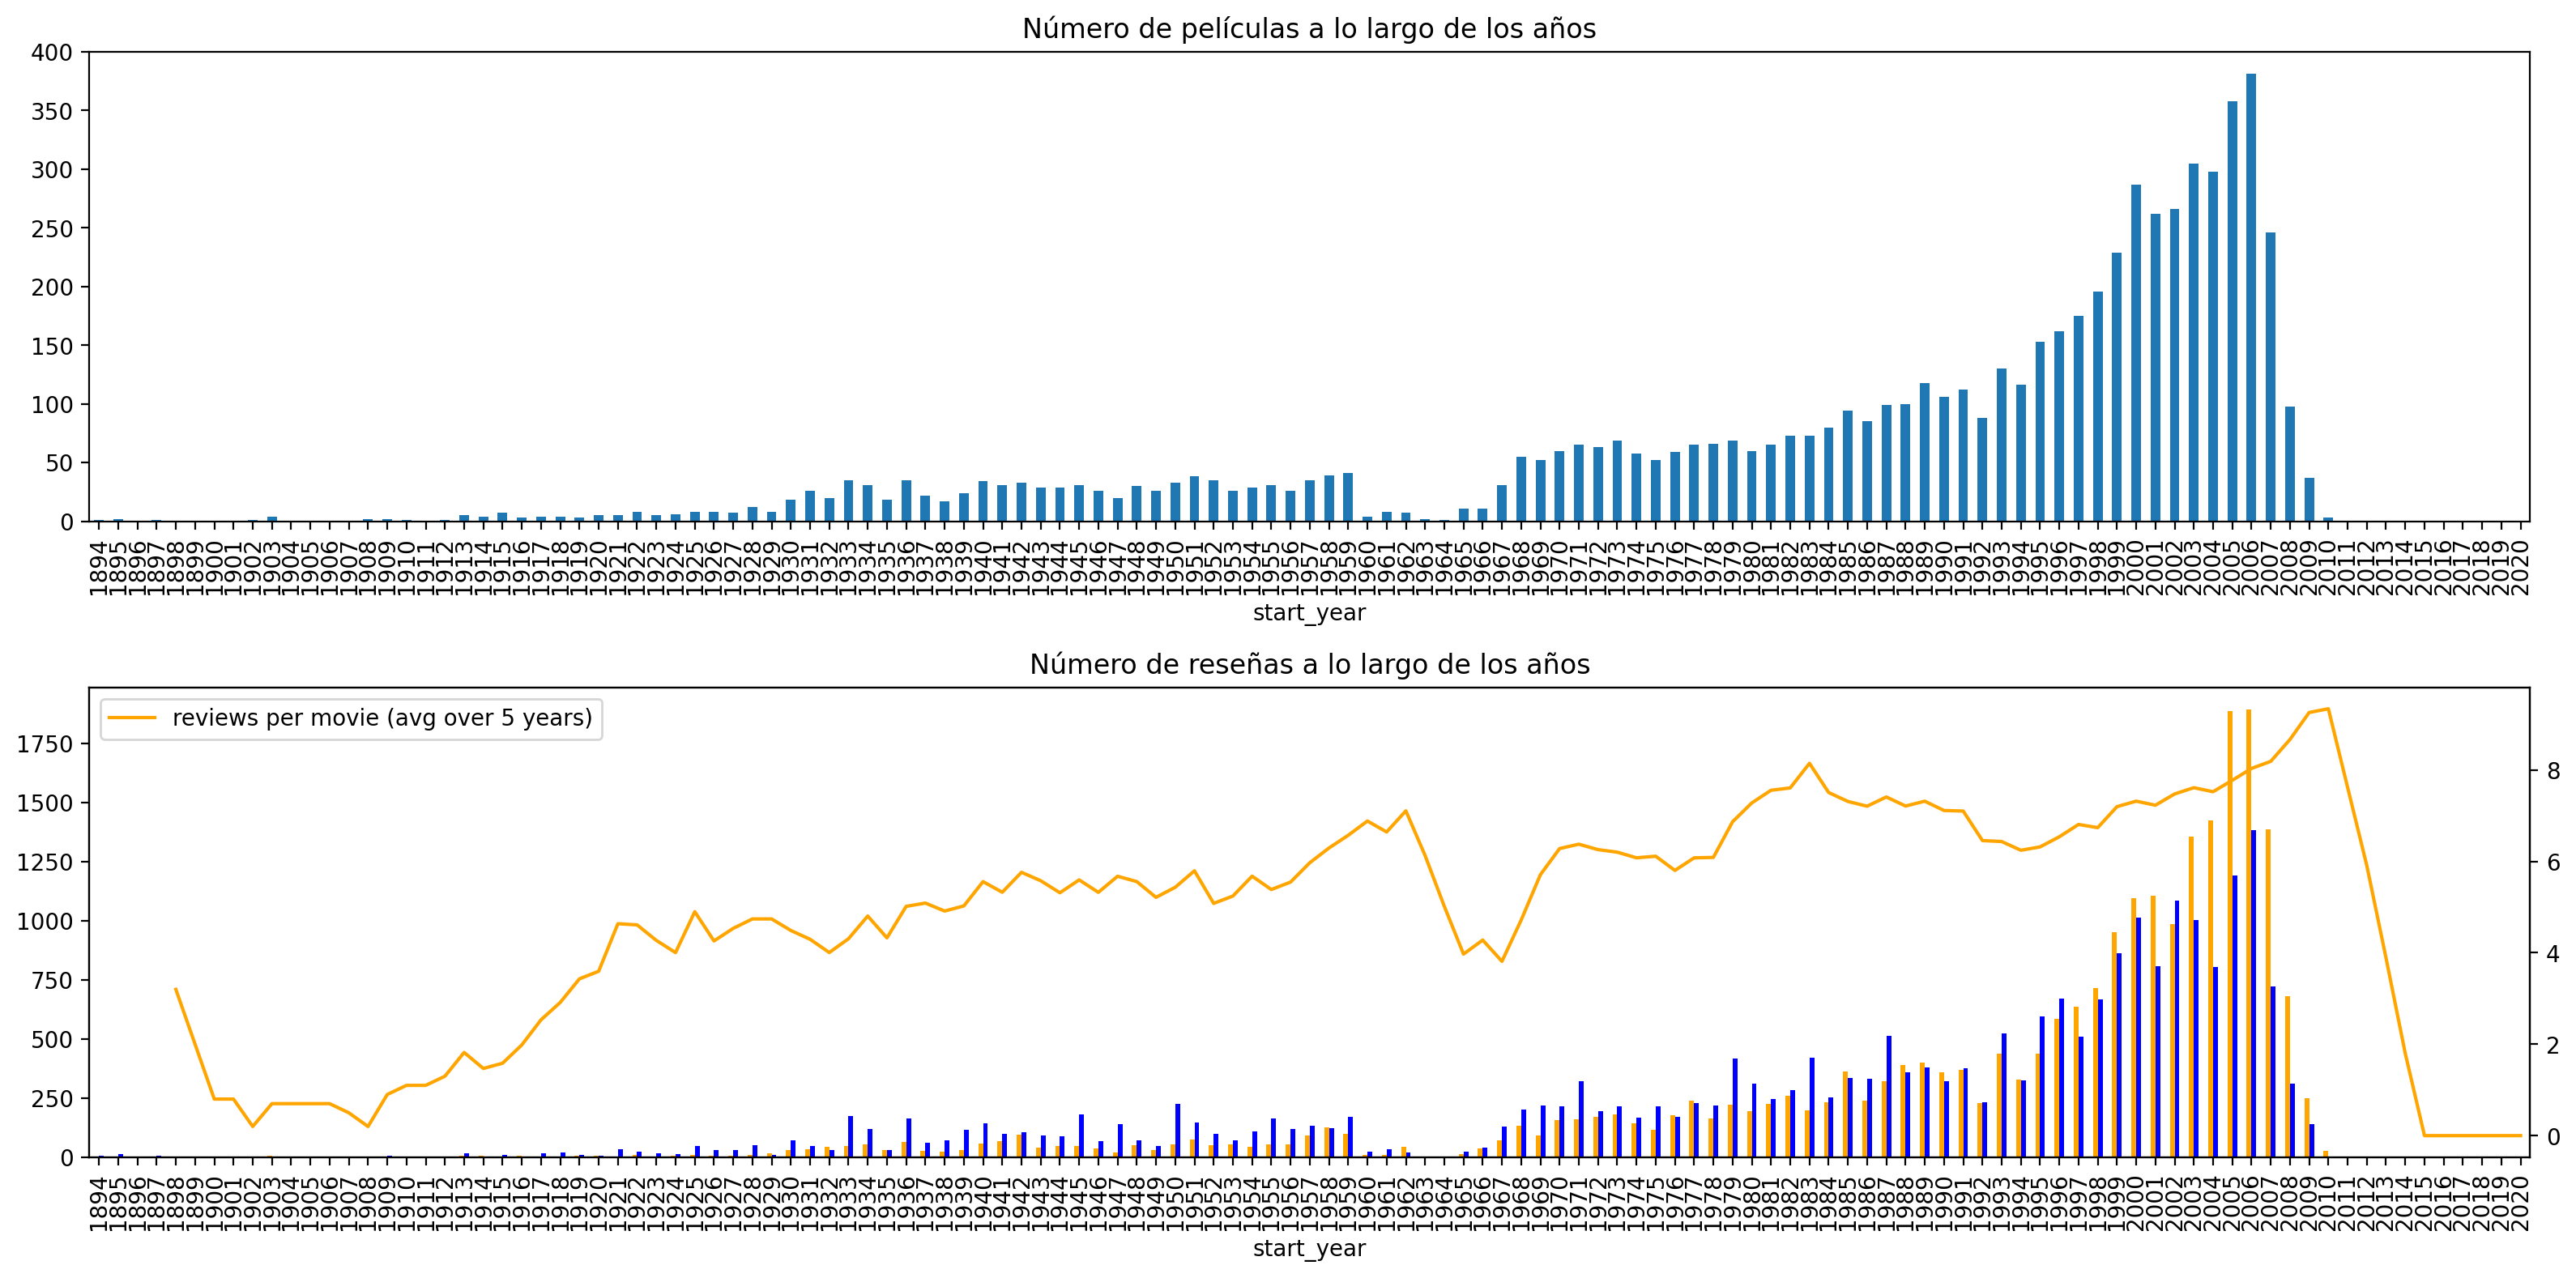

In [32]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')
ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft2.plot(kind='bar', label='#reviews (neg, pos)', ax=ax, color=['orange', 'blue'])#, stacked=True
#plt.legend(['0 = Naranja', '1 = Azul'], title="Categoría", loc="upper right")

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)

axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Podemos ver que a lo largo de los años, empezando por 1894 el numero de peliculas ha incrementando bastante, parece que el inicio fue duro hasta se observa que se mantuvo estatico desde 1930 a 1959. Despues de esto, hubo una fuerte decaida y para 1967 empezaron a salir mas peliculas y la industria parace que creció exponencialmente; con el mayor pico en el 2006. Despues de este año parece que la indrustria se debilito un poco, sin embargo no tenemos datos actuales ya que estos datos corresponden hasta el 2010.

En general en la segunda grafica podemos ver que mientras mas peliculas se generaban, entre 1997 y el 2010, las criticas negativas predominaban, mientras que cuando empezaban a salir peliculas antes de 1997, aparte de no se tantas peliculas, parece que la critica era buena para ellas. Eso puede ser porque no habia tanta comparacion y tanta tecnologia para como en los 2000s que se buscaba mejor calidad y una mejores historias que contar.

Entonces en promedio la cantidad de reseñas por pelicula por cada 5 años mantiene una tendecia de crecimiento, luego desciende y despues de esa caida abrupta vuelve a crecer y se mantiene por algunos años.



Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

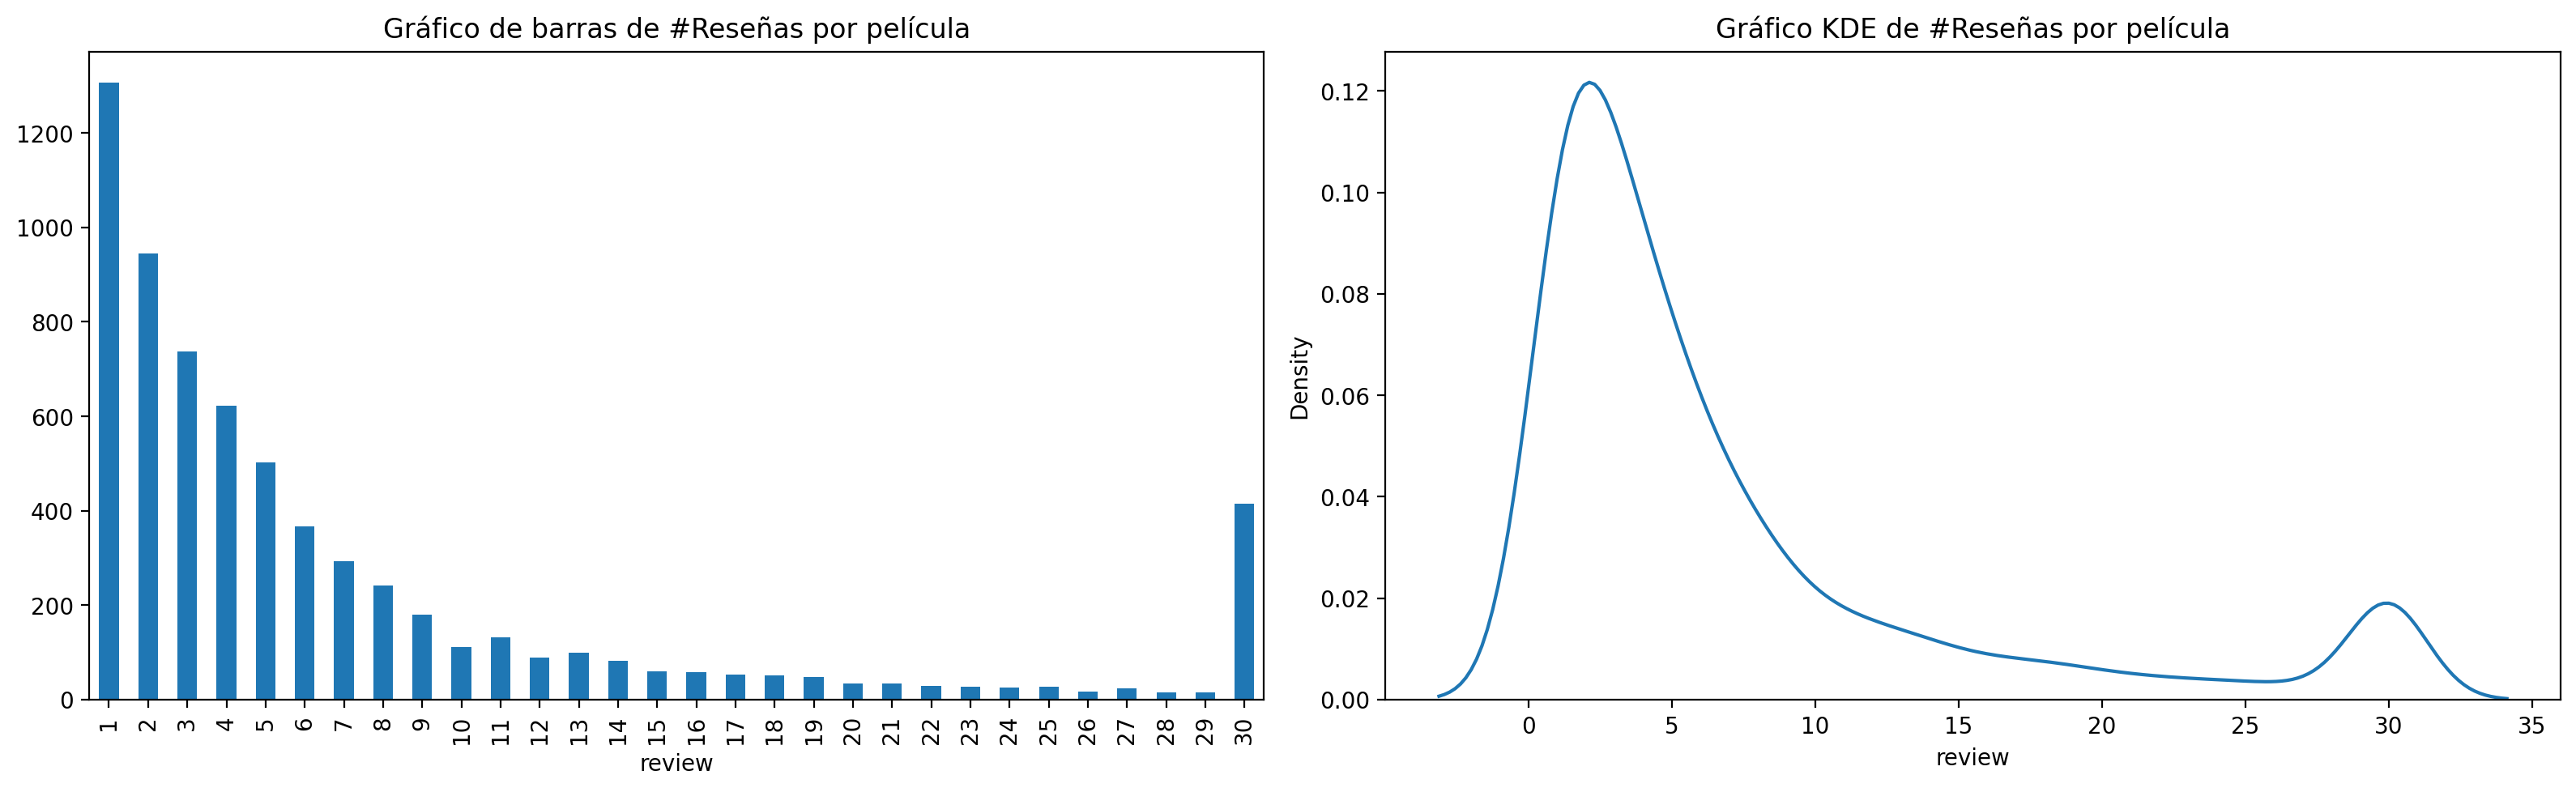

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [34]:
df_reviews['pos'].value_counts()

pos
0    23715
1    23616
Name: count, dtype: int64

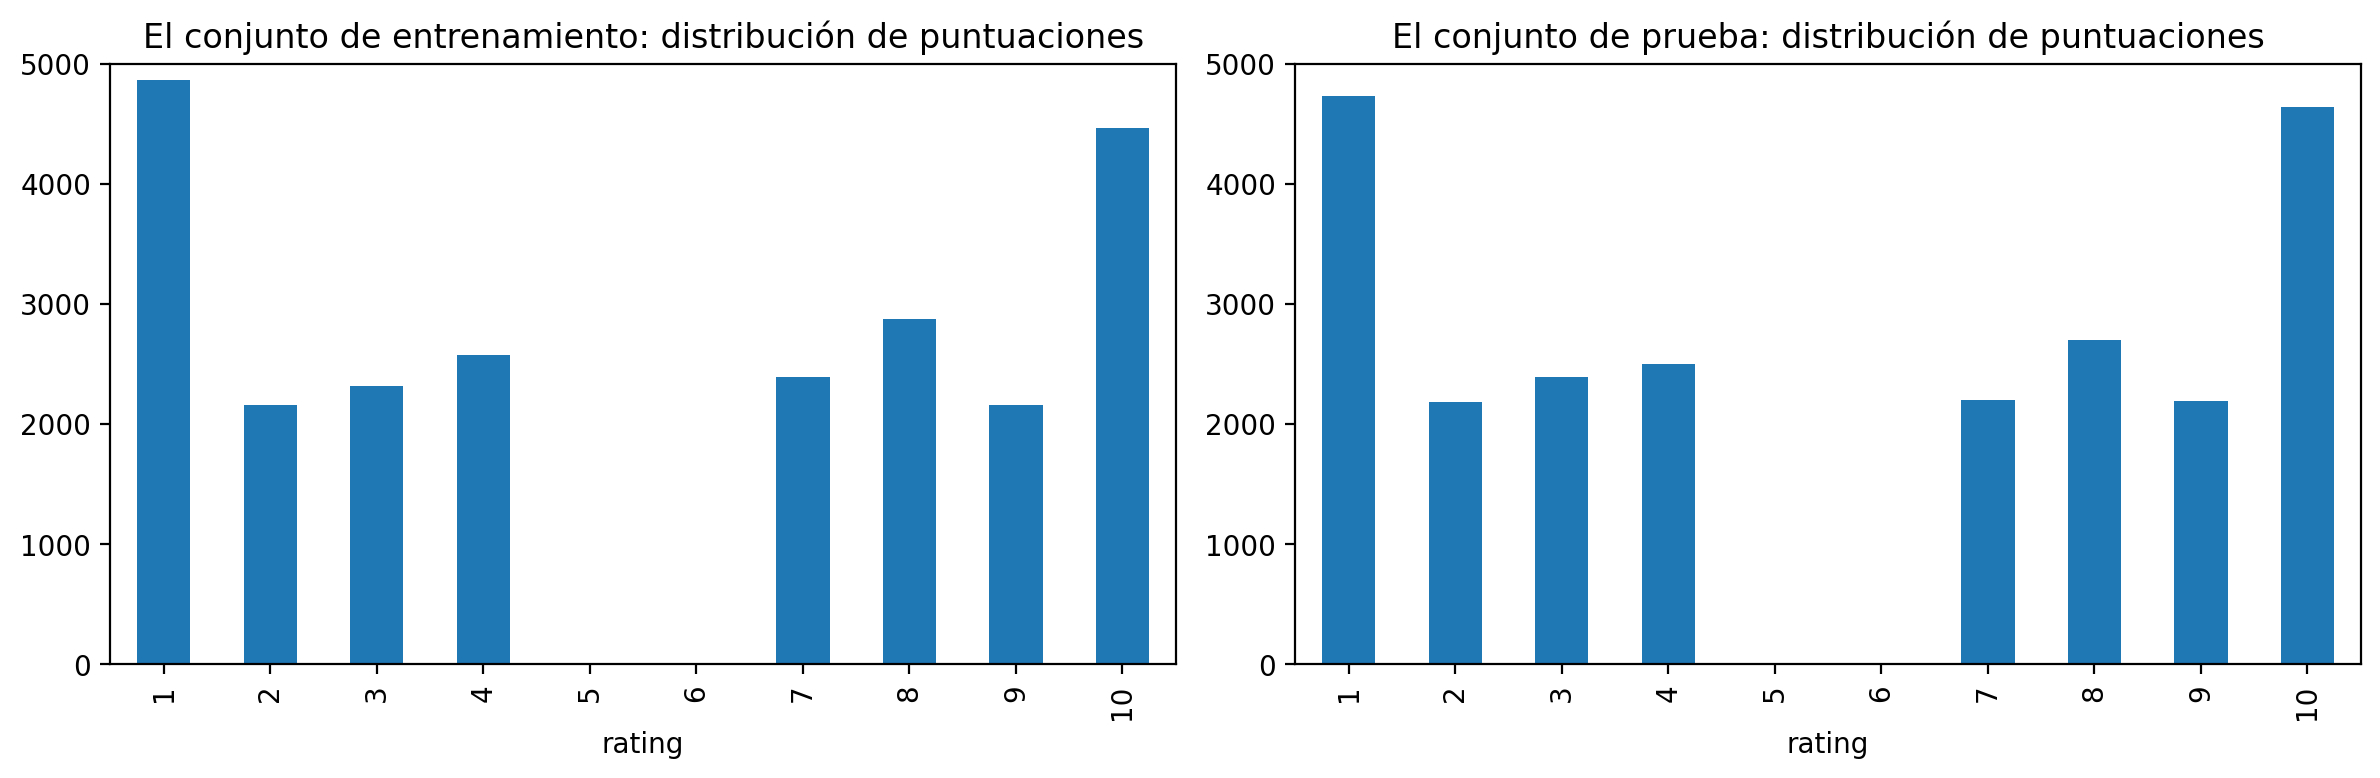

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

C:\Users\jimen\AppData\Local\Temp\ipykernel_38244\1324160450.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\jimen\AppData\Local\Temp\ipykernel_38244\1324160450.py:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
C:\Users\jimen\AppData\Local\Temp\ipykernel_38244\1324160450.py:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\jimen\AppData\Local\Temp\ipykernel_38244\1324160450.py:31: UserWarning: 

Support for a

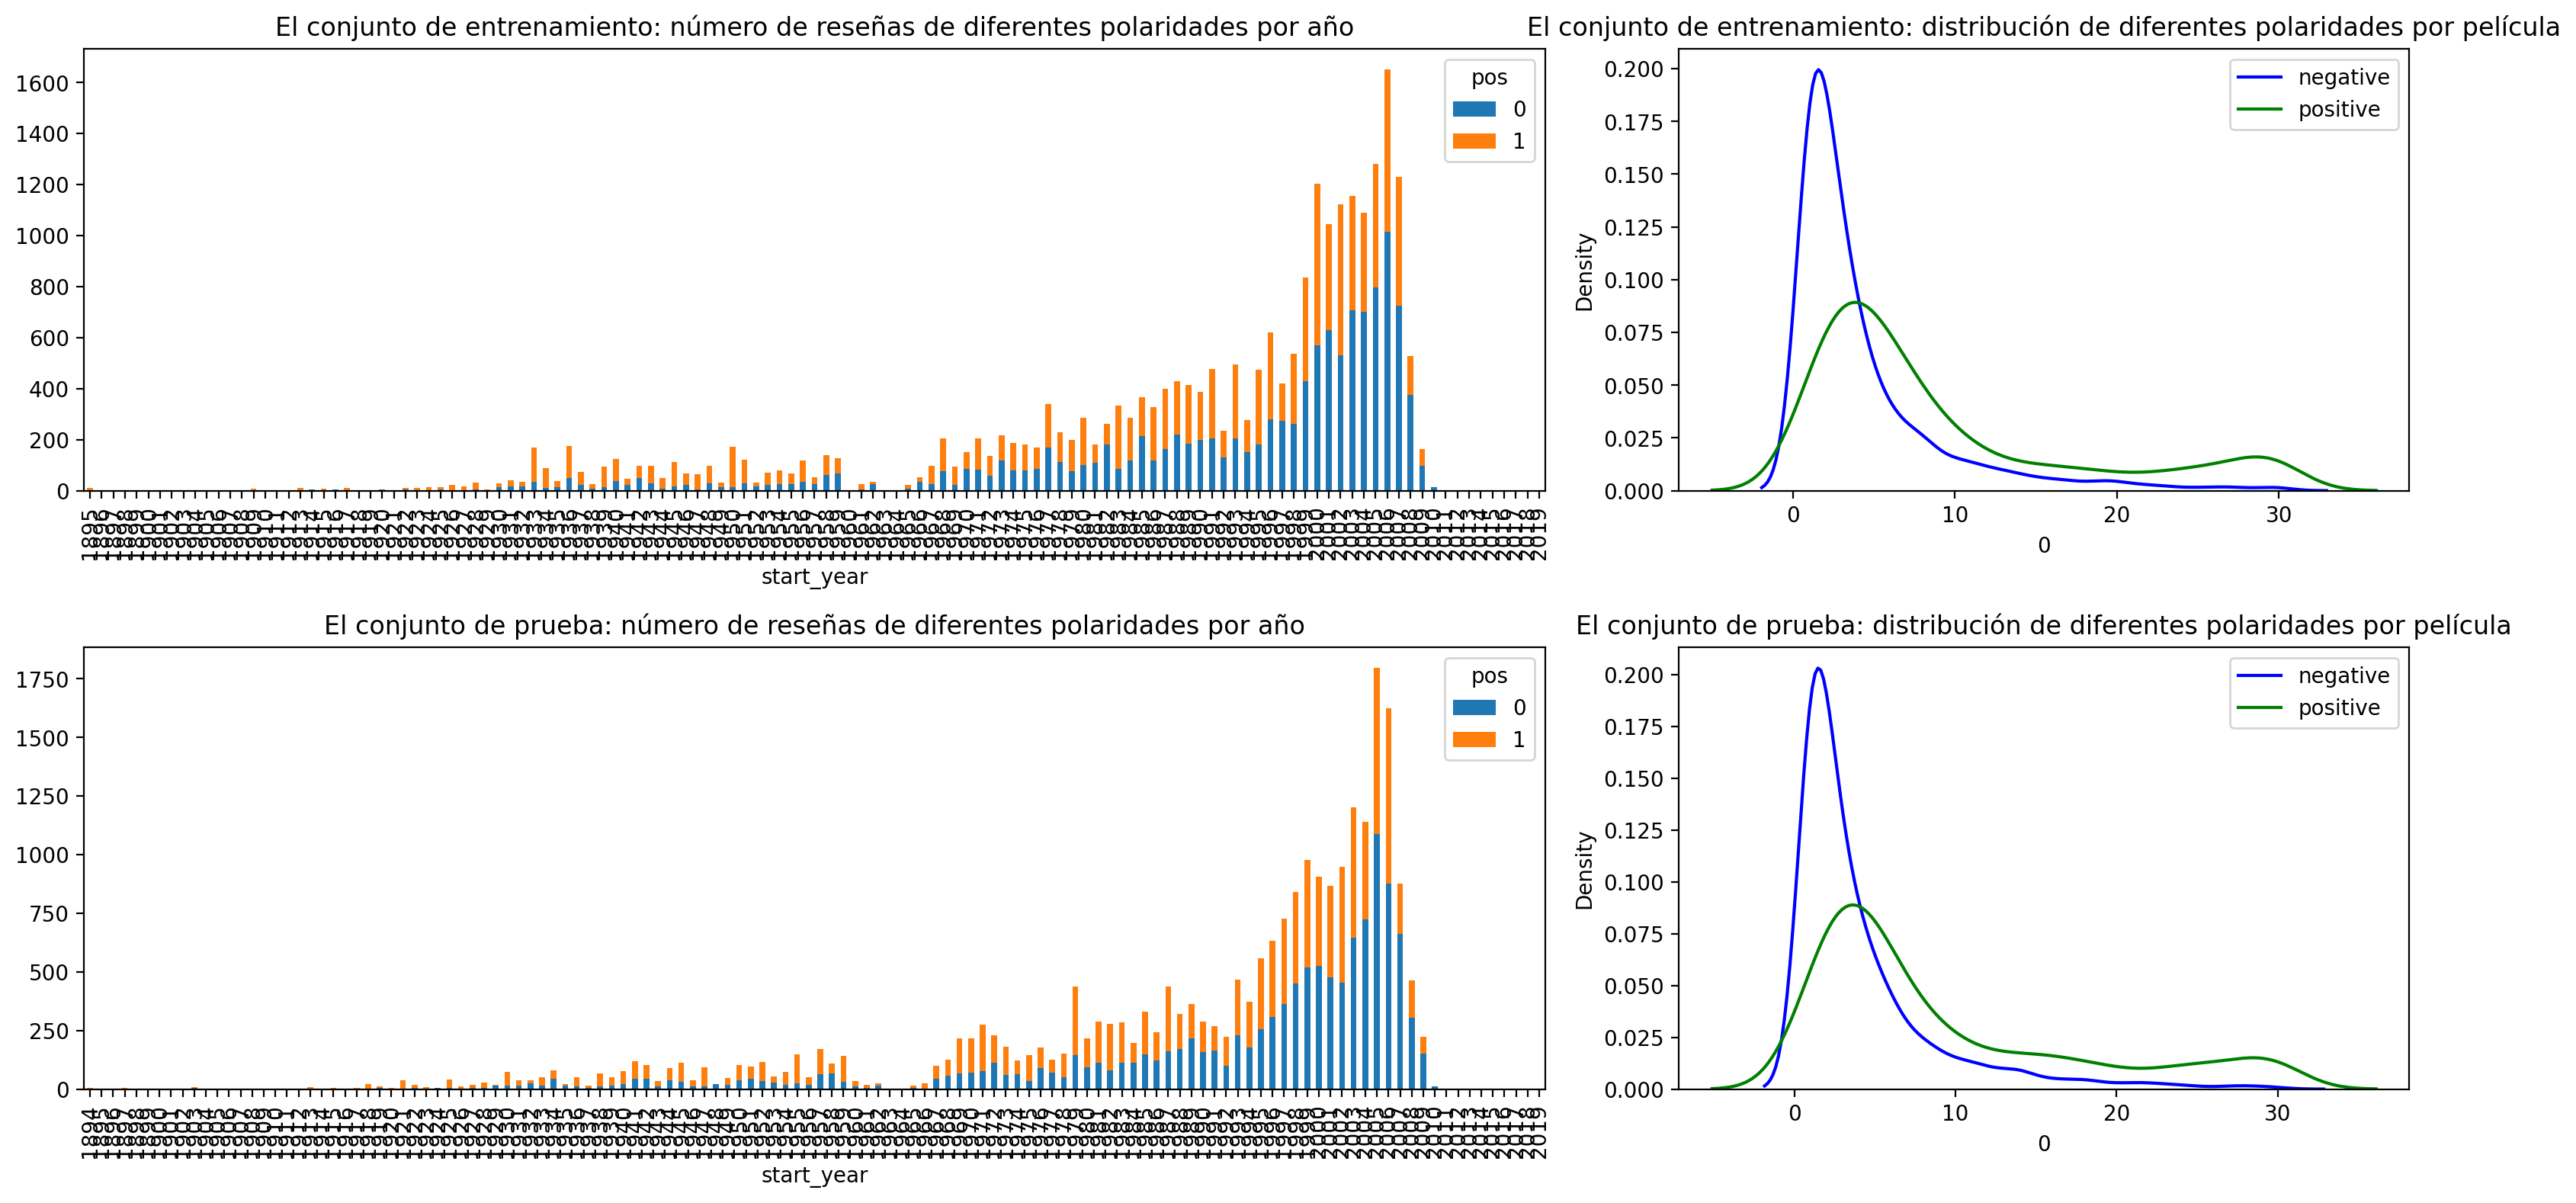

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [37]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
        #print(eval_stats)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(3)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

+ Utilizaremos la libreria spacy para lemantizar las reseñas.
+ Para codificar los datos categoricos usaremos la libreria Ordinal Encoder para poder normalizar los datos en numericos. 


In [38]:
nlp = spacy.load('en_core_web_sm' , disable= ['parser' , 'ner'])

In [39]:
def clear_text(text):
    clean_text = re.sub(r'[^a-zA-Z\s]',' ',text)
    clean_text = " ".join(clean_text.split())
    return clean_text

In [40]:
def lemmatize(text):
    doc = nlp(text.lower())
    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_ )
    return ' '.join(lemmas)

In [41]:
"""NOTA. Dado la cantidad de resañas y que este proceso es muy largo,
toma 8 minutos en terminarlo."""
df_reviews['review_norm'] = df_reviews['review'].astype(str).apply(lambda x: lemmatize(clear_text(x)))

In [42]:
"""Observemos que las reseñas han sido lemmantizadas. """
print(df_reviews['review'].head(5),'\n')

print(df_reviews['review_norm'].head(5))

0    The pakage implies that Warren Beatty and Gold...
1    How the hell did they get this made?! Presenti...
2    There is no real story the film seems more lik...
3    Um .... a serious film about troubled teens in...
4    I'm totally agree with GarryJohal from Singapo...
Name: review, dtype: object 

0    the pakage imply that warren beatty and goldie...
1    how the hell do they get this make present its...
2    there be no real story the film seem more like...
3    um a serious film about troubled teen in singa...
4    I m totally agree with garryjohal from singapo...
Name: review_norm, dtype: object


In [43]:
"""Codificaremos los datos categoricos a numeros para tener todas las 
caracteristicas en un solo tipo de varible.  """
encoder = OrdinalEncoder()
encoder.fit(df_reviews[['title_type','primary_title','original_title','genres']])
df_reviews_encoded = encoder.transform(df_reviews[['title_type','primary_title','original_title','genres']])
df_reviews_encoded = pd.DataFrame(df_reviews_encoded, columns=['title_type', 
                                                               'primary_title', 'original_title', 'genres'])

df_number_only = df_reviews.select_dtypes(include=['number'])

In [44]:
print('Caracteristicas numericas -> \n',df_number_only.head())
print('\nCaracteristicas categoticas cofificadas-> \n',df_reviews_encoded.head())

Caracteristicas numericas -> 
    start_year  runtime_minutes  is_adult  average_rating  votes  rating  pos  \
0        1971            121.0         0             6.3   2218       1    0   
1        1971            121.0         0             6.3   2218       1    0   
2        2002             25.0         0             6.3    184       3    0   
3        2002             25.0         0             6.3    184       7    1   
4        2002             25.0         0             6.3    184       9    1   

    idx  
0  8335  
1  8336  
2  2489  
3  9280  
4  9281  

Caracteristicas categoticas -> 
    title_type  primary_title  original_title  genres
0         0.0            0.0             0.0   263.0
1         0.0            0.0             0.0   263.0
2         1.0            1.0             1.0   288.0
3         1.0            1.0             1.0   288.0
4         1.0            1.0             1.0   288.0


In [59]:
df_complete = pd.concat([df_number_only, df_reviews_encoded,df_reviews['review_norm'],df_reviews['ds_part']], axis='columns')
print(df_complete.head())

   start_year  runtime_minutes  is_adult  average_rating  votes  rating  pos  \
0        1971            121.0         0             6.3   2218       1    0   
1        1971            121.0         0             6.3   2218       1    0   
2        2002             25.0         0             6.3    184       3    0   
3        2002             25.0         0             6.3    184       7    1   
4        2002             25.0         0             6.3    184       9    1   

    idx  title_type  primary_title  original_title  genres  \
0  8335         0.0            0.0             0.0   263.0   
1  8336         0.0            0.0             0.0   263.0   
2  2489         1.0            1.0             1.0   288.0   
3  9280         1.0            1.0             1.0   288.0   
4  9281         1.0            1.0             1.0   288.0   

                                         review_norm ds_part  
0  the pakage imply that warren beatty and goldie...   train  
1  how the hell do t

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [ ]:
"""De la columna ds_part donde tenemos que peliculas con todas sus 
reseñas son parte del entrenamiento y cuales son de prueba. Podemos 
ver cuales son las caracteristicas con las que trabajaremos y el 
tamaño de cada grupo (train and test)"""

df_reviews_train = df_complete.query('ds_part == "train"').copy()
df_reviews_test = df_complete.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

df_reviews_train = df_reviews_train.drop(['pos', 'ds_part', 'idx'],axis=1)
df_reviews_test = df_reviews_test.drop(['pos', 'ds_part', 'idx'],axis=1)

print('Tamaño de las caracterisitas y cantidad de datos en el conjunto de entrenamiento ->',
      df_reviews_train.shape)
print('Tamaño de las caracterisitas y cantidad de datos en el conjunto de prueba ->',
      df_reviews_test.shape)
print('Caracterisitas a trabajar el conjunto de entrenamiento ->',
      df_reviews_train.columns)
print('Caracterisitas a trabajar el conjunto de prueba ->',
      df_reviews_test.columns)

(23796, 11)
(23535, 11)
Index(['start_year', 'runtime_minutes', 'is_adult', 'average_rating', 'votes',
       'rating', 'title_type', 'primary_title', 'original_title', 'genres',
       'review_norm'],
      dtype='object')
Index(['start_year', 'runtime_minutes', 'is_adult', 'average_rating', 'votes',
       'rating', 'title_type', 'primary_title', 'original_title', 'genres',
       'review_norm'],
      dtype='object')


Entonces tenemos 261 reseñas mas en el conjunto de entrenamiento que en el conjunto de prueba. 
Se dejaron las columnas de el año en que salió la pelicula, los minutos que dura la pelicula, si es para adultos o no, el rating promedio, los vatos, el rating, el tipo de titulo, el titulo, el titulo original, el genero y claro que la reseña lemantizada. 

## Trabajar con modelos

### Modelo 0 - Constante

Para la prueba de cordura se utilizará la libreria DummyClassifier con un modelo uniforme, donde se predice la clase al azar con igual probabilidad. Utilizaremos la funcion evalute_model pasando el modelo, el conjunto de entramiento, el conjunto de prueba y sus respectivos conjuntos con el objetivo para predecir la probalidad de que sea reseña positiva y de igual forma poder evaluar su exactitud, calcular su F1_score, ver la curva ROC y PCR. 

In [47]:
from sklearn.dummy import DummyClassifier

In [48]:
"""Considerando un modelo uniforme, donde se predice una clase al azar con igual probabilidad."""
dummy_clf = DummyClassifier(strategy= 'uniform', random_state= 12345)
dummy_clf.fit(df_reviews_train , train_target)

DummyClassifier(random_state=12345, strategy='uniform')

          train   test
Accuracy  0.501  0.498
F1        0.503  0.499
APS       0.499  0.498
ROC AUC   0.500  0.500


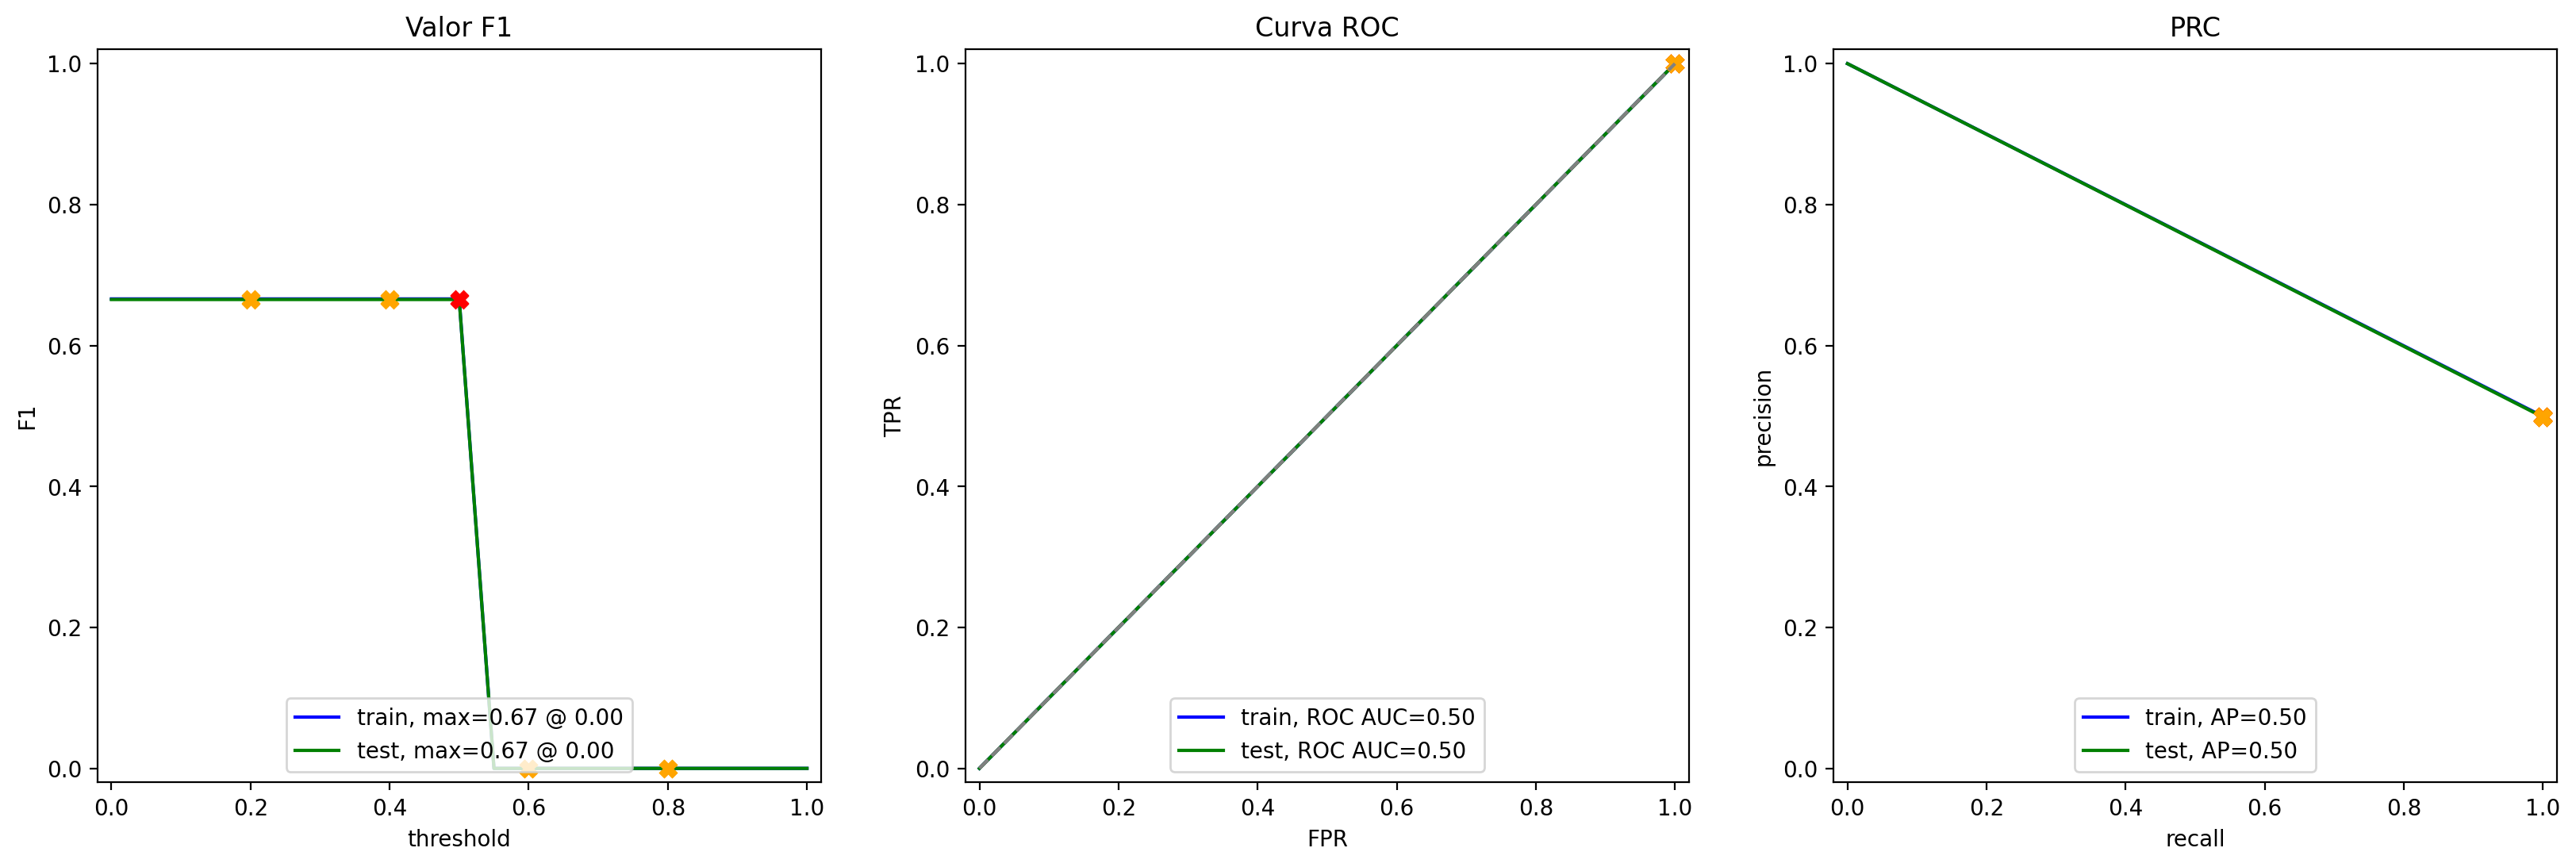

In [49]:
"""Utilizando la funcion de evaluacion para las metricas F1, APS y ROC AUC"""
evaluate_model(dummy_clf, df_reviews_train, train_target, df_reviews_test, test_target)

Para un modelo donde solo se predice una clase al azar con igual probabilidad y tenemos un valor de F1 de 0.49, no es malo, no es el mejor. Es casi como aventar un monera al aire y dejarlo al azar. Intentemos con otros modelos para ver que se comportan. 

### Modelo 1 - spaCy, TF-IDF y LR

Aplicaremos el modelo de Logistic Regression cambiando el threshold para determinar si es 0 o 1 (negativa o positiva) la reseña. 
Usaremos la libreria TF-IDF para vectorizar las reseñas y que el modelo trabaje con numeros en vez de con palabras. Le mandaremos las reseñas lemantizadas para que sea mas sencillo manejar la informacion. 

In [50]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jimen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [51]:
#stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words= 'english')
tf_idf = count_tf_idf.fit_transform(df_reviews_train['review_norm'])

In [52]:
print(tf_idf.shape)
print(type(tf_idf))

(23796, 58920)
<class 'scipy.sparse._csr.csr_matrix'>


In [53]:
feature_train_tf_idf = tf_idf
test_corpus = df_complete.query('ds_part == "test"').copy()

feature_test_tf_idf = count_tf_idf.transform(test_corpus['review_norm'])

print(feature_train_tf_idf.shape)
print(feature_test_tf_idf.shape)

(23796, 58920)
(23535, 58920)


In [54]:
model_LR = LogisticRegression()
model_LR.fit(feature_train_tf_idf, train_target)

LogisticRegression()

          train   test
Accuracy  0.930  0.875
F1        0.930  0.874
APS       0.979  0.943
ROC AUC   0.979  0.946


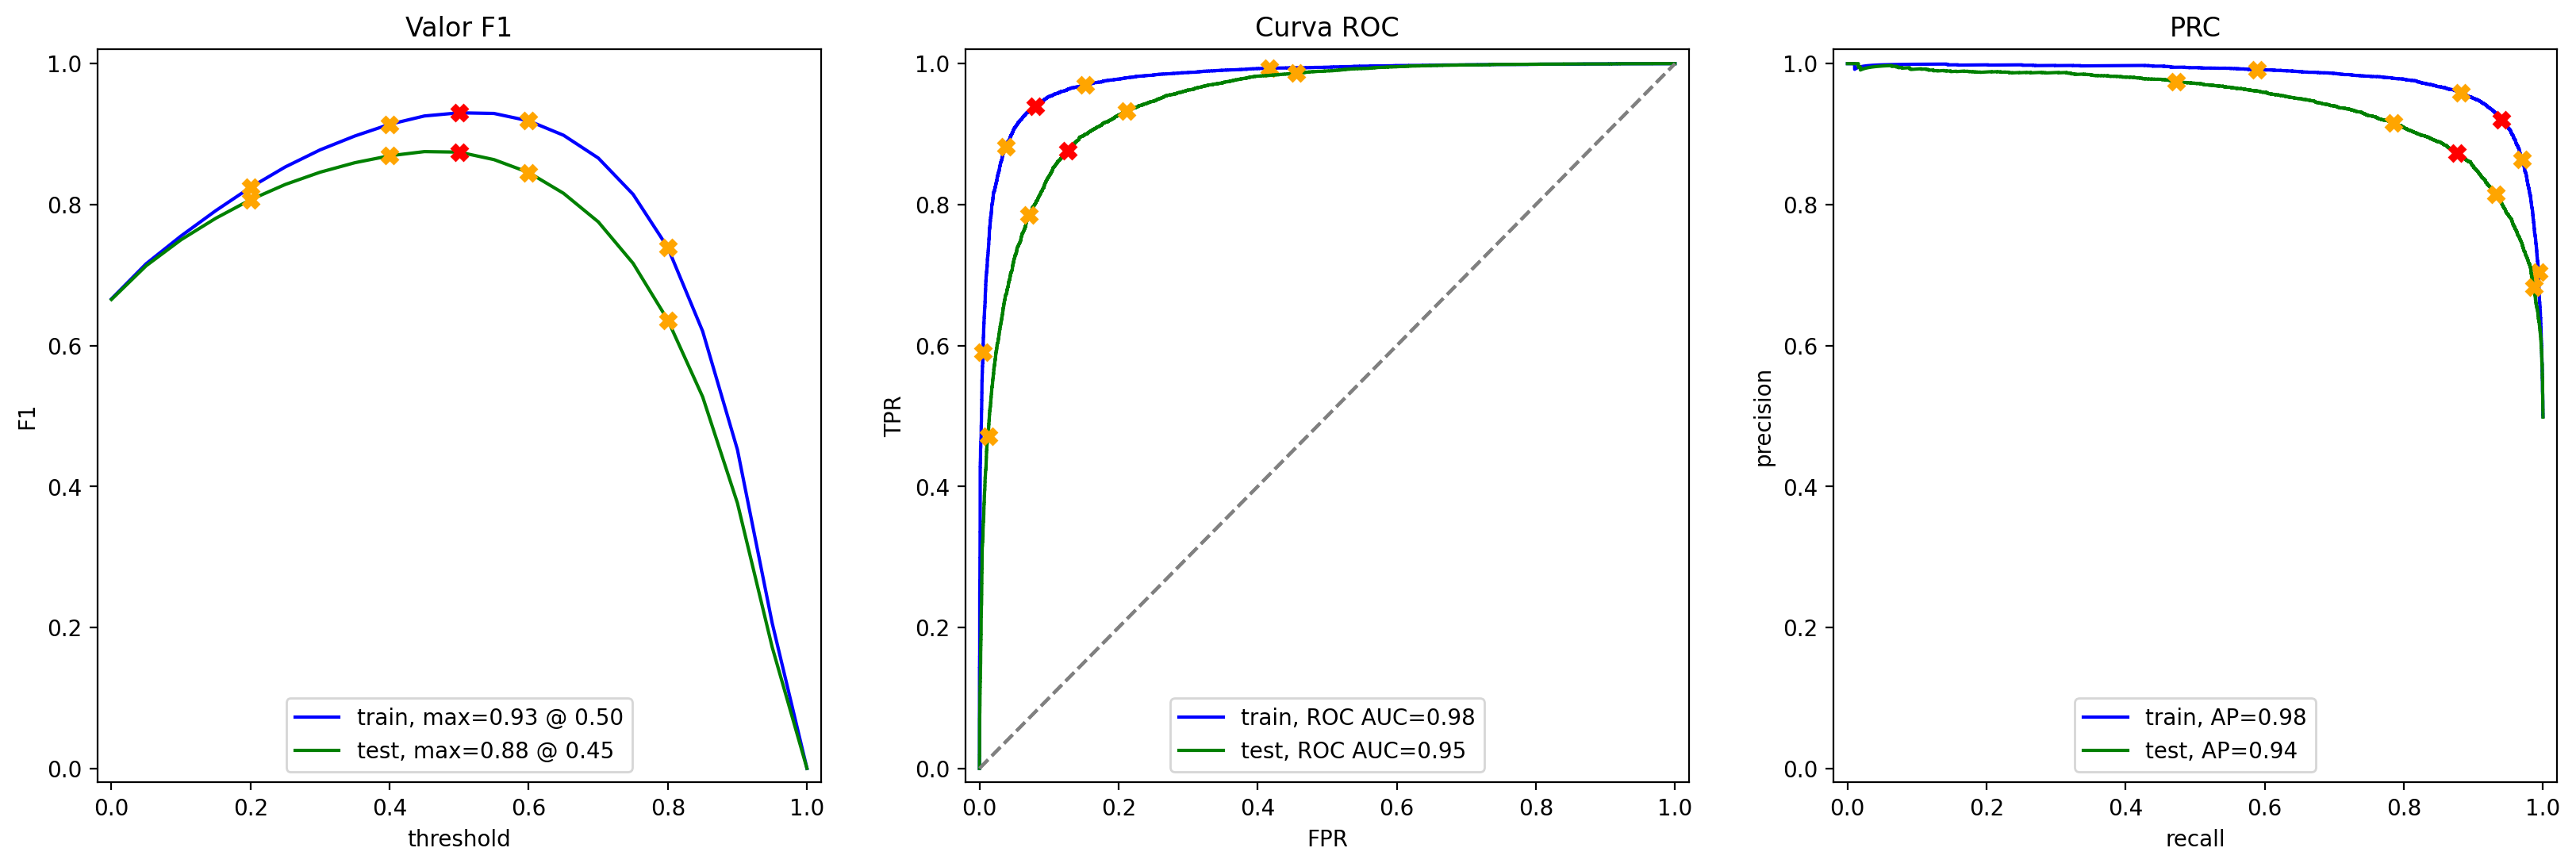

In [55]:
evaluate_model(model_LR, feature_train_tf_idf, train_target, feature_test_tf_idf, test_target)

### Modelo 2 - spaCy, TF-IDF y LGBMClassifier

In [56]:
import lightgbm as lgb

In [57]:
model_LGBM = lgb.LGBMClassifier( 
    boosting_type="gbdt",  # Gradient Boosting Decision Trees
    num_leaves=31,  # Hojas en cada árbol (controla la complejidad)
    learning_rate=0.05,  # Tamaño del paso en la optimización
    n_estimators=100,  # Número de árboles
    random_state=42
    )
model_LGBM.fit(feature_train_tf_idf, train_target)

[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.286959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 428306
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 9200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


LGBMClassifier(learning_rate=0.05, random_state=42)

          train   test
Accuracy  0.866  0.834
F1        0.868  0.835
APS       0.942  0.913
ROC AUC   0.943  0.916


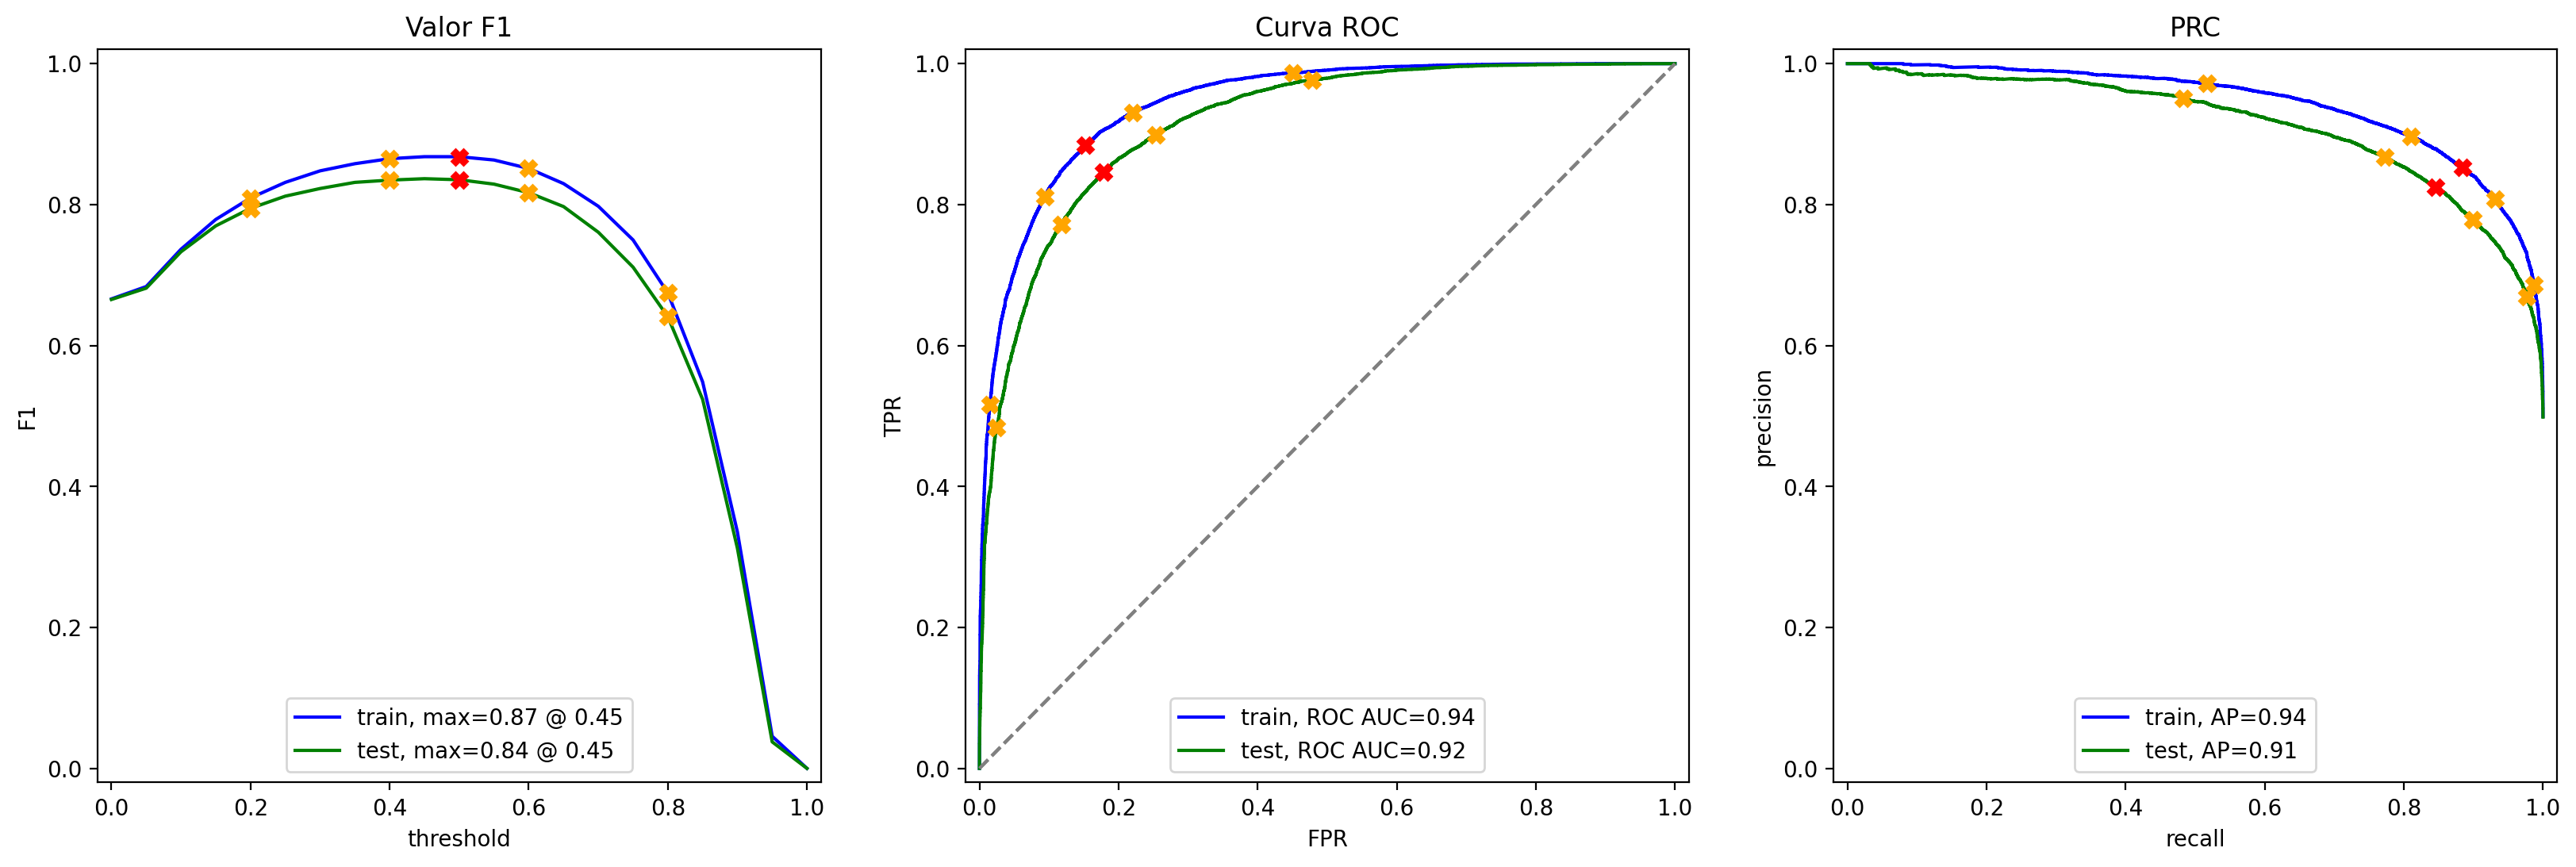

In [62]:
evaluate_model(model_LGBM, feature_train_tf_idf, train_target, feature_test_tf_idf, test_target)

###  Modelo 3 - BERT

In [65]:
import torch
import transformers

In [66]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

c:\Users\jimen\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jimen\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # texto al id de relleno de tokens junto con sus máscaras de atención 
       
    # <escribe tu código aquí para crear ids_list y attention_mask_list>
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')
    
    # obtener insertados en lotes
    
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <escribe tu código aquí para crear attention_mask_batch
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [ ]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

In [ ]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## Mis reseñas

In [ ]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = ...# <escribe aquí la misma lógica de normalización que para el conjunto de datos principal>

my_reviews

### Modelo 2

In [740]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  simplemente no me gustó no es mi tipo de película
0.16:  bueno estaba aburrido y me quedé dormido a media película 
0.54:  estaba realmente fascinada con la película
0.11:  hasta los actores parecían muy viejos y desinteresados y les pagaron por estar en la película qué
0.31:  no esperaba que el relanzamiento fuera tan bueno los escritores realmente se preocuparon por el material original
0.47:  la película tuvo sus altibajos pero siento que en general es una película decente sí la volvería
0.04:  qué pésimo intento de comedia ni una sola broma tiene sentido todos actúan de forma irritante y ruidosa ni siquiera a los ni
0.82:  fue muy valiente el lanzamiento en netflix realmente aprecio poder seguir viendo episodio tras epi


### Modelo 3

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Modelo 4

In [ ]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Modelo 9

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusiones

# Lista de comprobación

- [x]  Abriste el notebook
- [ ]  Cargaste y preprocesaste los datos de texto para su vectorización
- [ ]  Transformaste los datos de texto en vectores
- [ ]  Entrenaste y probaste los modelos
- [ ]  Se alcanzó el umbral de la métrica
- [ ]  Colocaste todas las celdas de código en el orden de su ejecución
- [ ]  Puedes ejecutar sin errores todas las celdas de código 
- [ ]  Hay conclusiones 